<a href="https://colab.research.google.com/github/douglacardoso/whatsapp-group-analysis/blob/master/whatsapp_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Librarys

In [1]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import re
import nltk
import pandas as pd
import numpy as np
import emoji
from collections import Counter
from PIL import Image
import random
plt.style.use('ggplot')

# 1. Loading text

In [2]:
# read text from file 
file_location = ('data/chat_tagarelas.txt')
with open(file_location, "r", encoding="utf-8") as f:
    data = f.read()
    data = ' '.join(data.split('\n'))

# 2. Manipulating
## 2.1. Creating a data frame

In [3]:
#separate user messages and datetime of the chat
pattern_1 = r'\d+/\d+/\d+,\s\d+[:]\d+\s\w+'
pattern_2 = r'\d+/\d+/\d+,\s\d+[:]\d+\s\w+\s\-'   

user_messages = re.split(pattern_2, data)[4:] # variable          
message_dates =  re.findall(pattern_1, data)[3:] # variable

# load user messages and dates into dataframe
df = pd.DataFrame({'user_message':user_messages, 'message_date': message_dates})

# convert message_date type
df['message_date'] = pd.to_datetime(df['message_date'], format='%m/%d/%y, %I:%M %p')

df.rename(columns={'message_date': 'date'}, inplace=True)

# print head 
df.head()

,user_message,date
0,"Guibs CCB POLITRECO: Eita, mais tagarelas",2021-01-15 23:27:00
1,Douglas Cardoso: <Media omitted>,2021-01-15 23:28:00
2,"Douglas Cardoso: roi, ou melhor, a paz de Deus",2021-01-15 23:29:00
3,Gabriel Novaes CCB IME: IRAAAAA,2021-01-15 23:30:00
4,Gabriel Novaes CCB IME: Amém,2021-01-15 23:30:00


## 2.2. Separete into columns

In [4]:
# separate users and messages 
users = []
messages = []
for message in df['user_message']:
    entry = re.split('([\w\W]+?):\s', message)
    if entry[1:]:
        users.append(entry[1])
        messages.append(entry[2])
    else:
        users.append('group_notification')
        messages.append(entry[0])

df['user'] =  users
df['message'] = messages
df.drop(columns=['user_message'], inplace=True)

df.tail()

,date,user,message
12213,2021-03-28 01:00:00,Guibs CCB POLITRECO,Hahahahahaha
12214,2021-03-28 01:11:00,+55 11 98142-5988,Aos cursos que são mais voltados para humanas ...
12215,2021-03-28 01:13:00,+55 11 98142-5988,Ademais todas as ciências são oriundas da filo...
12216,2021-03-28 01:13:00,+55 11 98142-5988,Pena que o irmão Gabriel de filo não ta aqui hah
12217,2021-03-28 01:26:00,Guibs CCB POLITRECO,"Concordo, Cesinha! Falou tudo."


## 2.3. Numbers to Names

In [5]:
# remove spaces and mapping some users
# strip
df['user'] = [user.strip() for user in df['user']]

mapping_users = {'+55 19 98296-0425': 'Victor Scagion',
                 '+55 11 97173-7327': 'Julia Farma CCBUSP',
                 '+55 13 99764-7677': 'Felipe Monteiro',
                 '+55 11 96185-2730': 'Giuliana Piro',
                 '+55 11 94798-8115': 'Rodrigo Passos',
                 '+55 11 94271-3654': 'Rebecca Ferreira'}

df['user'] = df['user'].replace(mapping_users)

## 2.4. Data cleaning

In [6]:
# 1. remove all the <Media omitted> messages
media = df[df['message'] == '<Media omitted> ']

print("Total number of Images + Videos Shared + Stickers: ", len(media))
df.drop(media.index, inplace=True)

# 2. remove all group notifications
notifications = df[df['user'] == 'group_notification']

print("Total Group Notifications: ", len(notifications))
df.drop(notifications.index, inplace=True)

# reset the index 
df.reset_index(inplace=True, drop=True)
df.tail()


Total number of Images + Videos Shared + Stickers:  1156
Total Group Notifications:  25


,date,user,message
11032,2021-03-28 01:00:00,Guibs CCB POLITRECO,Hahahahahaha
11033,2021-03-28 01:11:00,+55 11 98142-5988,Aos cursos que são mais voltados para humanas ...
11034,2021-03-28 01:13:00,+55 11 98142-5988,Ademais todas as ciências são oriundas da filo...
11035,2021-03-28 01:13:00,+55 11 98142-5988,Pena que o irmão Gabriel de filo não ta aqui hah
11036,2021-03-28 01:26:00,Guibs CCB POLITRECO,"Concordo, Cesinha! Falou tudo."


# 3. Who is most active in the group 

In [7]:
print("Amount of messages sent by user")

df.groupby('user')['message'].count().sort_values(ascending=False).head(10)

Amount of messages sent by user


user
Gabriel Novaes CCB IME    1256
Guibs CCB POLITRECO       1098
Victor Scagion            1084
Raíssa CCB USP             834
Julia Farma CCBUSP         819
Felipe Monteiro            641
Giuliana Piro              526
Rodrigo Passos             408
lionel                     322
Rebecca Ferreira           306
Name: message, dtype: int64

# 4. Frequently used emojis in the group

In [8]:
# init a Counter instance
emoji_counter = Counter()

# get all emojis in emoji package - language in english
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI['en'].keys())

# creating a regex compile with all emojis split by '|'
r = re.compile('|'.join(re.escape(p) for p in emojis_list))

# counting 
for index, row in df.iterrows():
    emojis_found = r.findall(row['message'])
    for emoji_f in emojis_found:
        emoji_counter[emoji_f] +=1

# show
for item in emoji_counter.most_common(10):
     print(f'{item[0]} - {item[1]}')


😂 - 753
❤ - 178
🥳 - 174
🤣 - 118
🥺 - 107
🥰 - 97
🏻 - 96
🎉 - 76
🤩 - 75
🏽 - 64


# 5. Sleep Cycles of the group

Text(0.5, 1.0, 'At what time do we talk most?')

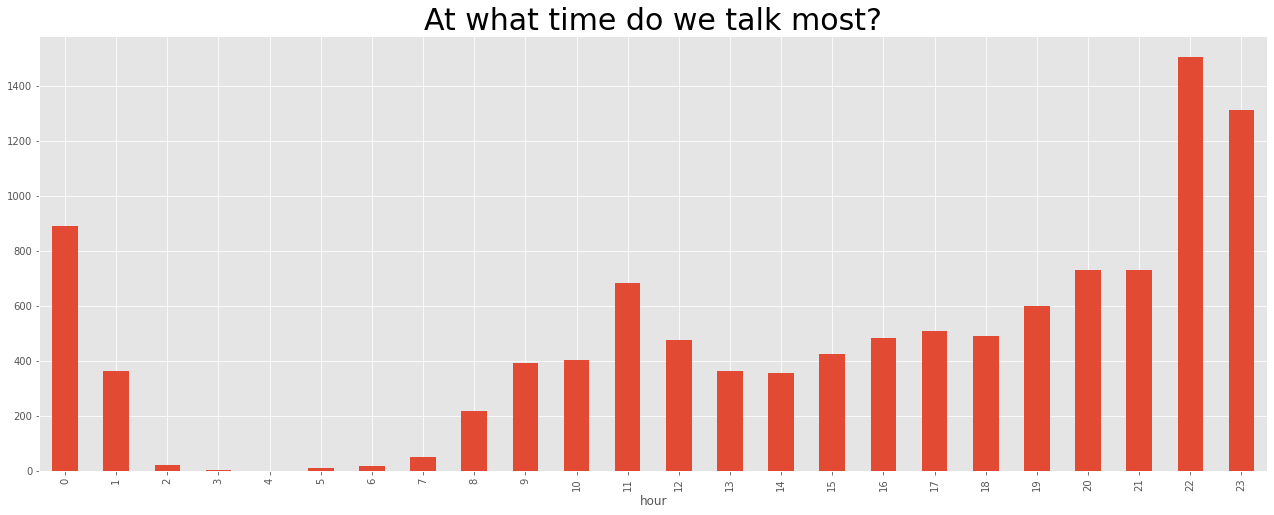

In [9]:
# creating a hour column 
df['hour'] = df['date'].apply(lambda x: x.hour)

# redefining columns order 
df = df[['date', 'hour', 'user', 'message']]

# plot 
df.groupby(['hour']).size().sort_index().plot(x="hour", kind='bar', figsize=(22,8))
plt.title('At what time do we talk most?', fontsize=30)

# 6. Word Cloud

In [10]:
# get an array from image.png
mask = np.array(Image.open('img/mask-cloud.png'))

In [11]:
# update stopwords 
stopwords = set(nltk.corpus.stopwords.words('portuguese'))
stopwords.update(['fui', 'sem', 'ei', 'fez', 'viu', 'estou', 'quero', 'ver', 'vou', 
                  'tenho', 'foi', 'ne', 'entao', 'então', 'assim', 'já', 'Gente', 
                  'essa', 'tá', 'ta', 'muito', 'e', 'é', 'quem', 'k', 'kk', 'kkk', 
                  'kkkk', 'kkkkk', 'q', 'pra', 'aí', 'bem', 'pq', 'tbm', 'Deu',
                  'acho', 'sim', 'tudo', 'vai', 'aqui', 'ser', 'dá', 'Ai', 'Aí',
                  'sei', 'ter', 'vcs','vc', 'Vc', 'lá'])

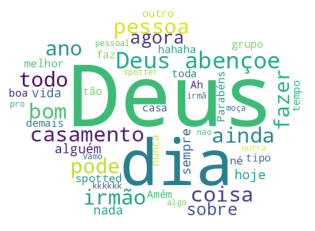

In [12]:
# join all messages in a unique string/text
all_summary = " ".join(word for word in df['message'].values)

# creating a wordcloud
wordcloud = WordCloud(background_color ='white', 
                stopwords = stopwords,
                mask = mask,
                min_font_size = 10)

# apply wordloud to text
wordcloud.generate(all_summary)

# plot
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.imshow(wordcloud)

## 6.1. Wordcloud custom color

In [13]:
# func for vari
def blue_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(204, 50%%, %d%%)" % random.randint(10, 50)

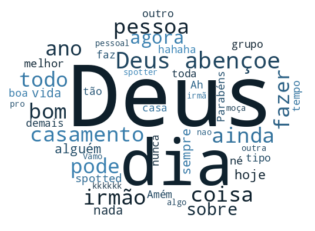

In [14]:
wc_blue = wordcloud.recolor(color_func=blue_color_func, random_state=3)

plt.imshow(wc_blue, interpolation="bilinear")
plt.axis("off")
plt.show()

In [15]:
wc_blue.to_file('img/cloud_group.png')